# Basic eval function

The "Query Languages for Neural Networks" paper describes how we can implement
an *eval* term in FO(SUM), which returns the output of a model for a given
input. Our goal is to translate this term into a SQL query. In this chapter, we
start from the simplest case, gradually building up in complexity in later
chapters.

## Creating the model

To get started, we first need a neural network. We always assume a fully
connected feed-forward neural network with ReLU activation layers.

We create a simple network with the following properties:

- 1 input neuron
- 1 output neuron
- 2 hidden layers with 2 neurons each

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import utils.sqlite as db
import utils.nn as nn
import pandas as pd

# Add a manual seed for reproducibility.
torch.manual_seed(223)

# Define a simple function to train the network on.
def f(x):
    if x < 0:
        return 0
    elif 0 <= x < 5:
        return x
    elif 5 <= x < 10:
        return 10-x
    else:
        return 0

# The function only does interesting stuff between x=0 and x=10, so limit the
# training data to that area.
x_train = np.linspace(-5, 15, 1000)
y_train = np.array([f(x) for x in x_train])

model = nn.ReLUFNN(input_size=1, hidden_size=2, num_hidden_layers=2, output_size=1)
nn.train(model, x_train, y_train, save_path="models/basic_eval.pt")

> Since we will be creating a lot of ReLU-FFNs, we move this to a separate
> module called `utils.nn`. The code can be found [here](utils/nn.py).

With our model trained and ready, let's compare it to the original function.

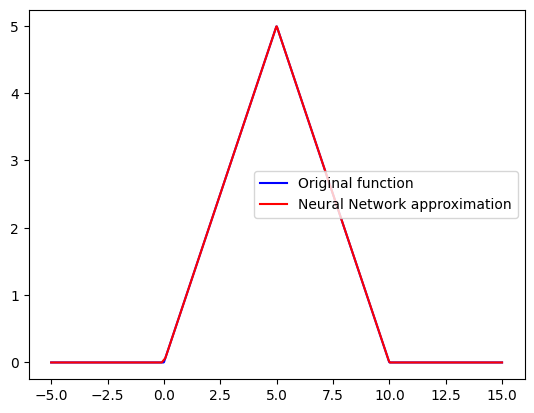

In [2]:
model.eval()
predicted = model(torch.tensor(x_train, dtype=torch.float32).unsqueeze(1)).detach().numpy()

plt.plot(x_train, y_train, 'b', label='Original function')
plt.plot(x_train, predicted, 'r', label='Neural Network approximation')
plt.legend()
plt.show()

We can see that the neural network nicely approximates the original function.

## Creating the database



A neural network can be seen as a directed graph, where each node has a bias
value and each edge a weight value. We store this graph representation in
SQLite, a relational database. The schema looks as follows:

![Database schema](./assets/db_schema.png)

The node's `name` property holds the name of the node as defined in PyTorch and
is purely informational. 

The following code creates this schema and imports the model.

In [3]:
db.load_pytorch_model_into_db(model)

> Similar to the model creation, this code is included from a separate module
> `utils.sqlite` that can be found [here](utils/duckdb.py).

To give an idea what the inserted data looks like, we'll fetch all nodes and
edges.

In [4]:
display(pd.read_sql_query("SELECT name, bias FROM node", db.con))
display(pd.read_sql_query("SELECT * FROM edge", db.con))

,name,bias
0,input.0,0.000000
1,linear_relu_stack.0.bias.0,0.581110
2,linear_relu_stack.0.bias.1,-2.342160
3,linear_relu_stack.2.bias.0,-0.393416
4,linear_relu_stack.2.bias.1,-0.183346
5,linear_relu_stack.4.bias.0,-0.000223


,src,dst,weight
0,1,2,0.768845
1,1,3,0.468451
2,2,4,0.622264
3,2,5,0.360834
4,3,4,-2.024734
5,3,5,-1.199183
6,4,6,1.238098
7,5,6,1.470374


To reassure us that these weights and biases are correct, we can use
`model.state_dict()` to compare them to the tensors of the PyTorch model.

In [5]:
model.state_dict()

OrderedDict([('linear_relu_stack.0.weight',
              tensor([[0.7688],
                      [0.4685]])),
             ('linear_relu_stack.0.bias', tensor([ 0.5811, -2.3422])),
             ('linear_relu_stack.2.weight',
              tensor([[ 0.6223, -2.0247],
                      [ 0.3608, -1.1992]])),
             ('linear_relu_stack.2.bias', tensor([-0.3934, -0.1833])),
             ('linear_relu_stack.4.weight', tensor([[1.2381, 1.4704]])),
             ('linear_relu_stack.4.bias', tensor([-0.0002]))])

## Creating the eval query

The paper constructs the $eval$ term as follows:

- Let $val_1, \ldots, val_m$ be additional weight constant symbols representing
  input values.
- Then the following term $t_1(u)$ describes the value of any neuron $u$ in the
  first hidden layer:

  $
  t_1(u) := ReLU(b(u) + w(in_1, u) \cdot val_1 + \ldots + w(in_m, u) \cdot val_m) 
  $

  With $w(a, b)$ being the weight value of the edge that connects node $a$ to
  node $b$, and $b(a)$ the bias of node $a$.
- We can now inductively define the weight term $t_l$ for any subsequent layer
  $l > 1$:
  
  $
  t_l(u) := ReLU(b(u) + \Sigma_{x:E(x,u)} w(x,u) \cdot t_{l-1}(x)) 
  $
- The value of the $j$-th output neuron is given as follows:

  $
  eval_j := ReLU(b(out_j) + \Sigma_{x:E(x,out_j)} w(x,out_j) \cdot t_{l}(x)) 
  $

  Where $l$ is the number of the last hidden layer.

We will now translate this term into a SQL query. Keep in mind that the paper
assumes the number of layers $l$ is known. For this reason, we will explicitly
not use SQL's recursive capabilities in this stage and instead build the query
manually. We'll discuss recursion in a later chapter.

The full query is given here:

```sql
WITH input_values AS (
    SELECT $val1 AS input_value
),
input_nodes AS (
    SELECT id, bias
    FROM node
    WHERE id NOT IN
    (
        SELECT dst FROM edge
    )
),
t1 AS (
    SELECT
        MAX(
            0,
            n.bias + SUM(e.weight * v.input_value)
        ) AS t1,
        e.dst AS id
    FROM edge e
    JOIN input_nodes i ON i.id = e.src
    JOIN node n ON e.dst = n.id
    CROSS JOIN input_values v
    GROUP BY e.dst, n.bias
),
t2 AS (
    SELECT
        MAX(
            0,
            n.bias + SUM(e.weight * t1.t1)
        ) AS t2,
        e.dst AS id
    FROM edge e
    JOIN t1 ON t1.id = e.src
    JOIN node n ON e.dst = n.id
    GROUP BY e.dst, n.bias
),
outputs AS (
    SELECT
        n.bias + SUM(e.weight * t2.t2) AS output_value,
        e.dst AS output_node_id
    FROM edge e
    JOIN t2 ON t2.id = e.src
    JOIN node n ON e.dst = n.id
    GROUP BY e.dst, n.bias
)
SELECT * FROM outputs;
```

We rely heavily on Common Table Expressions (CTEs) to improve readability. Let's
break the query down step-by-step.

```sql
WITH input_values AS (
    SELECT $val1 AS input_value
)
```

The neural network accepts only one input value. `$val1` is a placeholder that
will receive the input value when executing the query.

```sql
input_nodes AS (
    SELECT id
    FROM node
    WHERE id NOT IN
    (
        SELECT dst FROM edge
    )
)
```

The set of input nodes is defined as the nodes that do not have any incoming
edge.

```sql
t1 AS (
    SELECT
        MAX(
            0,
            n.bias + SUM(e.weight * v.input_value)
        ) AS t1,
        e.dst AS id
    FROM edge e
    JOIN input_nodes i ON i.id = e.src
    JOIN node n ON e.dst = n.id
    CROSS JOIN input_values v
    GROUP BY e.dst, n.bias
)
```

This is the term $t_1(u)$ that represents the values of the first layer's hidden
neurons.

- `FROM edge e JOIN input_nodes i ON i.id = e.src` selects all edges that start
  from an input node, which means that `e.dst` is the ID of the hidden neuron in
  the first layer.
- We only have one input value, so `CROSS JOIN input_values v` simply adds them
  to the output relation.
- `GROUP BY e.dst, n.bias` combined with `SUM` represents the summation over all
  the input weights for each hidden neuron.
- `MAX(0, x)` represents the ReLU activation function.

The result is a relation that has a row for each hidden neuron in the first
layer.

```sql
t2 AS (
    SELECT
        MAX(
            0,
            n.bias + SUM(e.weight * t1.t1)
        ) AS t2,
        e.dst AS id
    FROM edge e
    JOIN t1 ON t1.id = e.src
    JOIN node n ON e.dst = n.id
    GROUP BY e.dst, n.bias
)
```

This CTE is very similar to $t_1$. It is the inductive case where we calculate
the values of the second hidden layer by relying on the ones we calculated for
the first hidden layer.

```sql
outputs AS (
    SELECT
        n.bias + SUM(e.weight * t2.t2) AS output_value,
        e.dst AS output_node_id
    FROM edge e
    JOIN t2 ON t2.id = e.src
    JOIN node n ON e.dst = n.id
    GROUP BY e.dst, n.bias
)
SELECT * FROM outputs;
```

As the final step we have another similar CTE. The main difference here is that
we omit the ReLU application. The result is the final value for each output
node.

## Running the query

Let's now run the query on the database to see of the result is identical to
that of the model's evaluation. The query is available in the file
[eval_generic_basic.sql](./queries/eval_generic_basic.sql).

In [6]:
with open('queries/eval_generic_basic.sql', 'r') as query_file:
    query = query_file.read()

nn_output = model(torch.tensor([5], dtype=torch.float32).unsqueeze(1)).detach().numpy()
sql_output = db.con.execute(query, {'val1': 5}).fetchone()

print(f"The neural network predicted {nn_output[0][0]}")
print(f"The SQL query calculated {sql_output[0]}")

The neural network predicted 4.999991416931152
The SQL query calculated 4.999991102643108


As we can see, the output is nearly identical. There is some difference, which
can be explained by different floating point precisions.

We can plot the neural network's output and the sql query's output for all
of our training data to see if they correspond nicely.

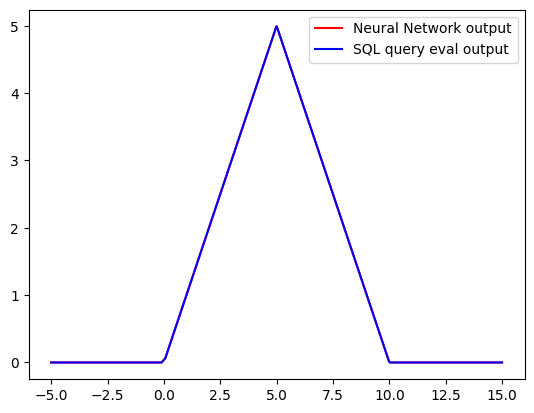

In [7]:
y_sql = []
for x in x_train:
    (y,_) = db.con.execute(query, {'val1': x}).fetchone()
    y_sql.append(y)

plt.plot(x_train, predicted, 'r', label='Neural Network output')
plt.plot(x_train, y_sql, 'b', label='SQL query eval output')
plt.legend()
plt.show()

## More hidden layers

Our basic FNN only has 2 hidden layers. We'll create a more complex network with
more layers to see how our query performs.

In [8]:
bigger_model = nn.ReLUFNN(input_size=1, output_size=1, hidden_size=4, num_hidden_layers=10)
nn.train(bigger_model, x_train, y_train, save_path="models/basic_eval_bigger.pt")
db.load_pytorch_model_into_db(bigger_model)

Since we do not rely on SQL's recursive capabilities, we have to explicitly
define each term in the query. We'll use python to automate this.

In [9]:
def eval_nn(model, input_value):
    # We have to divide by 2, since the state dict contains 2 entries for each
    # layer (one for the weights, the other for the biases).
    num_layers = int(len(model.state_dict()) / 2)

    # This first part of the query is identical to the basic query.
    query = """
        WITH input_values AS (
            SELECT $val1 AS input_value
        ),
        input_nodes AS (
            SELECT id
            FROM node
            WHERE id NOT IN
            (
                SELECT dst FROM edge
            )
        ),
        t1 AS (
            SELECT
                MAX(
                    0,
                    n.bias + SUM(e.weight * v.input_value)
                ) AS t1,
                e.dst AS id
            FROM edge e
            JOIN input_nodes i ON i.id = e.src
            JOIN node n ON e.dst = n.id
            CROSS JOIN input_values v
            GROUP BY e.dst, n.bias
        ),
        """

    # We then add each intermediary term t_l programmatically.
    for hidden_layer in range(2, num_layers):
        curr = hidden_layer
        prev = hidden_layer - 1
        query += f"""
            t{curr} AS (
                SELECT
                    MAX(
                        0,
                        n.bias + SUM(e.weight * t{prev}.t{prev})
                    ) AS t{curr},
                    e.dst AS id
                FROM edge e
                JOIN t{prev} ON t{prev}.id = e.src
                JOIN node n ON e.dst = n.id
                GROUP BY e.dst, n.bias
            ),
        """

    # The output is again identical to the basic query.
    prev = num_layers - 1
    query += f"""
        outputs AS (
            SELECT
                n.bias + SUM(e.weight * t{prev}.t{prev}) AS output_value,
                e.dst AS output_node_id
            FROM edge e
            JOIN t{prev} ON t{prev}.id = e.src
            JOIN node n ON e.dst = n.id
            GROUP BY e.dst, n.bias
        )
        SELECT * FROM outputs;
    """

    (y,_) = db.con.execute(query, {'val1': input_value}).fetchone()

    return y

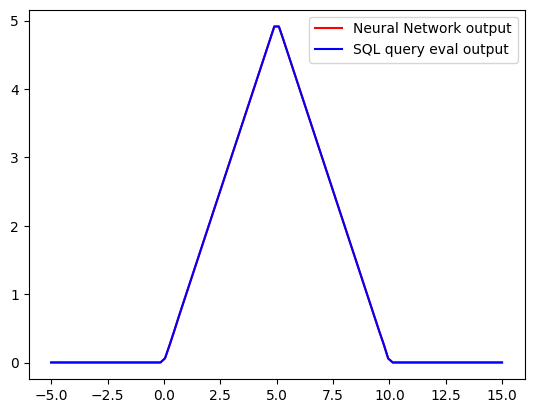

In [10]:
xs = np.linspace(-5, 15, 100)

predicted = bigger_model(torch.tensor(xs, dtype=torch.float32).unsqueeze(1)).detach().numpy()

y_sql = []
for x in xs:
    y = eval_nn(bigger_model, x)
    y_sql.append(y)

plt.plot(xs, predicted, 'r', label='Neural Network output')
plt.plot(xs, y_sql, 'b', label='SQL query eval output')
plt.legend()
plt.show()

As we can see, the query still performs as expected.

## Conclusion

We have shown that we can use SQL to evaluate a basic FNN. In the following
chapters, we'll gradually increase the complexity of the neural network and
adapt our query accordingly.